This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [ ]:
import numpy as np
import 
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

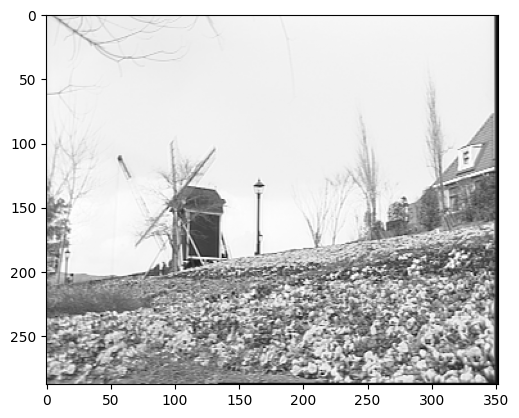

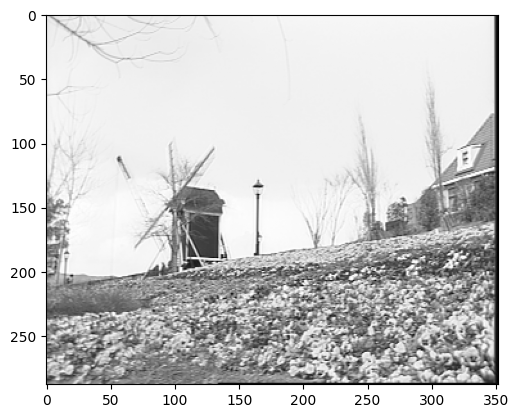

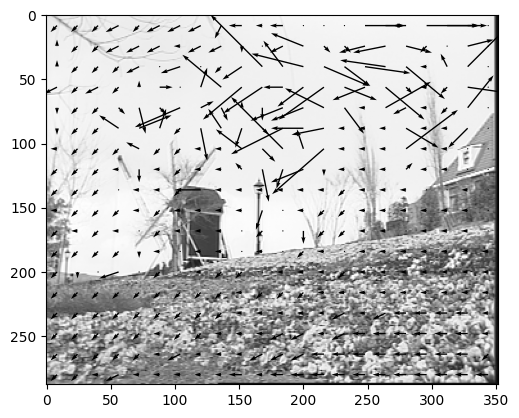

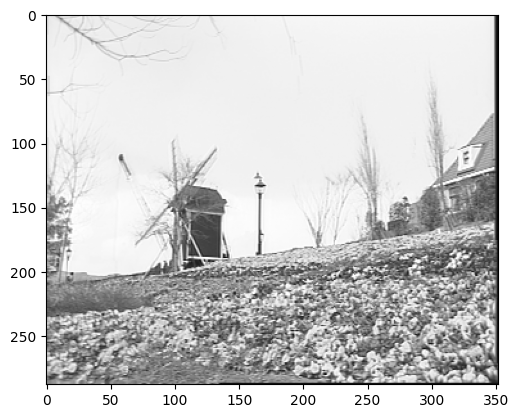

16.460076383673186


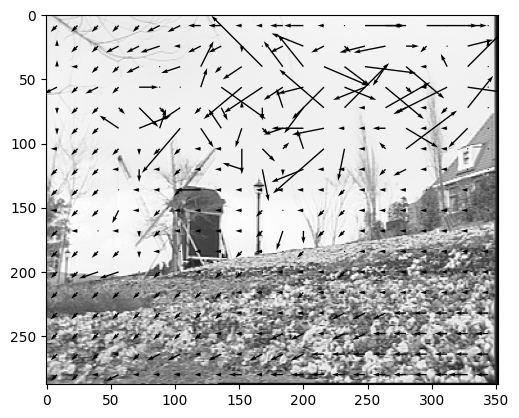

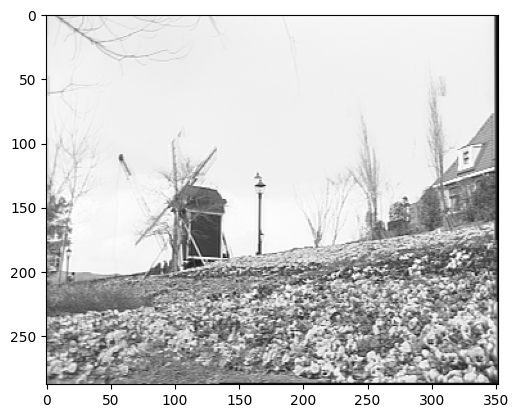

16.39962998394595


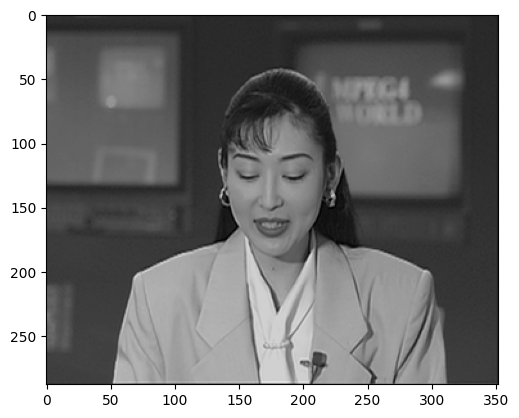

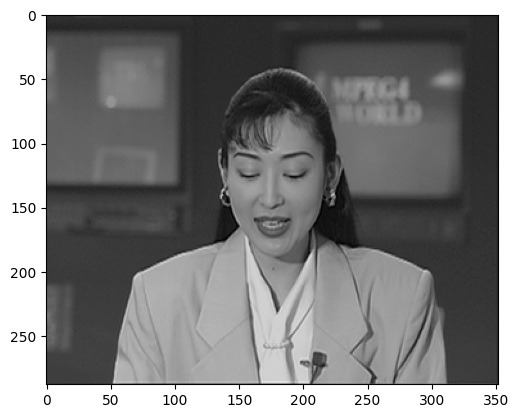

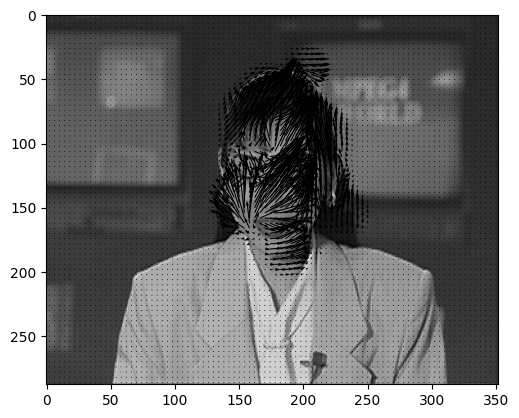

In [17]:
%run "TP1_motion_estimation-student-1on2 (2).ipynb"

# Parametric estimation

In this second practical work, we will work on parametric estimation, both using direct and indirect methods.

## I- Direct parametric estimation  
## I-1 Theoretical questions

**Infinite signal**

Let $a : (n,m) \in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

The 2D DTFT of $a$ is written as
$$
\hat{a}(u_x,u_y)
= \sum_{n\in\mathbb{Z}} \sum_{m\in\mathbb{Z}} a(n,m)\, e^{-i2\pi(u_x n + u_y m)}.
$$

If $b(n,m) = a(n+c,m+d)$, then by change of variables we get
$$
\hat{b}(u_x,u_y)
= e^{i2\pi(cu_x + du_y)} \hat{a}(u_x,u_y).
$$

So the ratio is
$$
\frac{\hat{b}(u_x,u_y)}{\hat{a}(u_x,u_y)}
= \exp\!\left(i2\pi(cu_x + du_y)\right),
$$
which is a pure phase term whose phase is a plane in frequency.

---

**Finite signal**

Now, $a : (n,m) \in \{0,1,\dots,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

The 2D DFT is
$$
\hat{A}(k_x,k_y)
= \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} a(n,m)\,
e^{-i2\pi \frac{k_x n + k_y m}{N}}.
$$

The ratio between DFTs behaves like a linear phase term when the two images differ only by a global translation and this translation is compatible with the periodic extension implicit in the DFT (or equivalently when wrap-around effects are negligible on the useful support). Under these conditions,
$$
\frac{\hat{B}(k_x,k_y)}{\hat{A}(k_x,k_y)}
= \exp\!\left(\frac{2i\pi(ck_x + dk_y)}{N}\right),
$$
and the slope of the phase plane gives the displacement components.

## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

In [2]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2bc3275a450>)

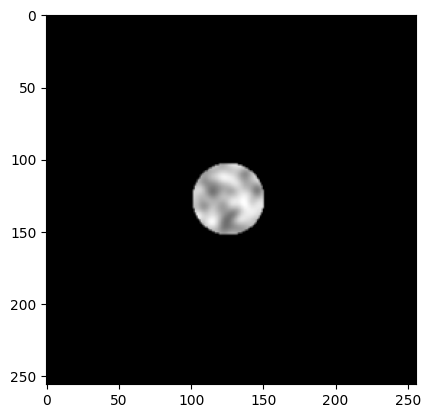

In [3]:
# Potentially add noise to the image
sigma = 0
im1 = im1 + sigma*np.random.randn(N, M)
plt.figure(),plt.imshow(im1,cmap='gray')

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [4]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2bc33d2b8f0>)

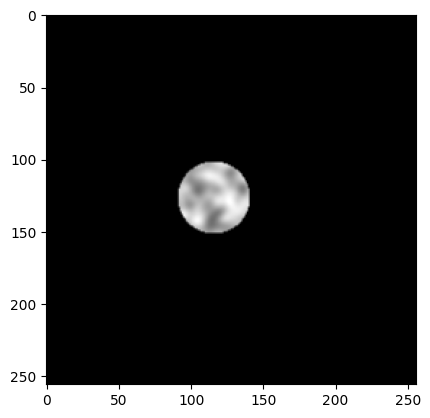

In [5]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**Answer:**

A practical way is to work with the Fourier ratio $R = IM2/IM1$. If the second image is only a translated version of the first one, this ratio should have unit magnitude and a phase that is linear with frequency coordinates. In other words, the phase of $R$ forms a plane whose slopes along the horizontal and vertical frequency axes are directly proportional to the translation components. So the pipeline is: compute both FFTs, compute the complex ratio, unwrap its phase in 2D, fit a plane (or estimate the median gradient), and finally convert the estimated slopes into pixel displacement values.


In [6]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

Compute the phase of the Fourier transform.

In [7]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [8]:
phi = angle2D(IM2/(IM1 + 1e-12))

Display phi. Is it a linear plane and why?

**Answer:**

Yes, in the ideal case it is approximately a linear plane. The reason is that a pure spatial translation becomes a complex exponential in the Fourier domain, and the phase of that exponential is affine in frequency. In practice the surface is never perfectly planar everywhere because of boundary effects, interpolation artifacts when creating the translated image, and sensitivity to noise where the Fourier magnitude is very small, but the dominant trend is still a plane and its slopes encode the motion parameters.


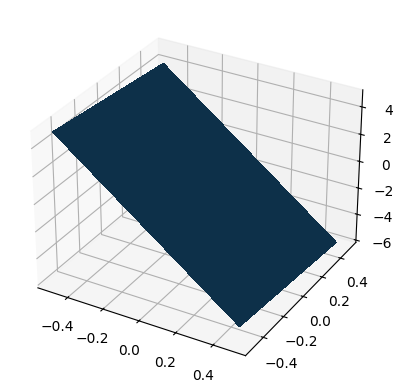

In [9]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)


Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [10]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns

    gy, gx = np.gradient(M, stepY, stepX)
    
    
    return gx,gy

In [11]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

In [12]:
print(GX)
print(GY)

-10.0
-1.0


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

The idea is to model the unwrapped phase map as a plane: $\phi(f_x,f_y) \approx a f_x + b f_y$. After centering and median filtering the phase to reduce local outliers, the code reshapes all pixel locations $(f_x,f_y)$ into a design matrix $A$ and reshapes the filtered phase into a vector. The least-squares estimate is then obtained with the pseudo-inverse, $\hat{\theta}=(A^{\dagger})b$, where $\hat{\theta}=[a\;b]^T$. These two coefficients are the slopes of the phase plane, so they directly provide the two translation parameters.


In [13]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [14]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [15]:
print(bEst)

[-9.99981832 -0.99999929]


**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

When there is no added noise, both gradient-median and least-squares plane fitting usually recover the translation very accurately, because the phase relation is close to the ideal linear model. With moderate noise, the estimates remain usable but become less stable: phase unwrapping is more fragile around low-energy frequencies, and this can bias the slope. The least-squares method is generally smoother because it uses all pixels globally, while the median-gradient method is often robust to isolated outliers. Repeating the experiment on Lena leads to similar conclusions, but texture distribution matters: richer frequency content tends to stabilize estimation, whereas flat areas make the phase less informative. Overall, both methods work well for integer shifts in clean conditions and degrade gracefully with noise, with least-squares often being slightly more consistent.


# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

0.0
0.0


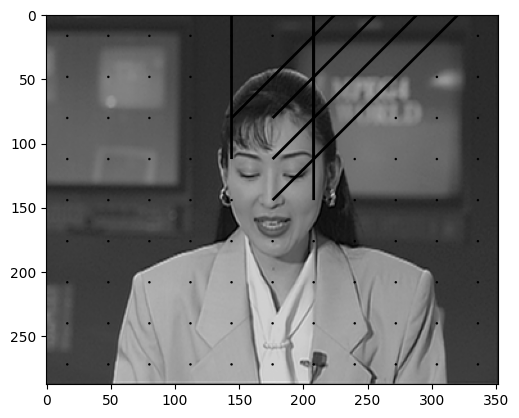

In [18]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

-7.558934039264938e-24
-1.9355035342026275e-60


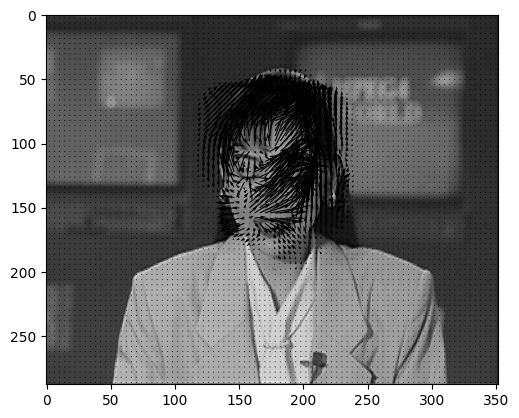

In [19]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)